In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import shutil
import os
import requests 
import time
import sqlite3
import random  
from datasets import Dataset 
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [7]:


results = {
    "Model": ["Logistic Regression", "Naive Bayes", "SVM", "Random Forest", "LSTM", "CNN", "BERT"],  # Added a comma between "Naive Bayes" and "SVM"
    "Accuracy": [0.85, 0.70, 0.88, 0.81, 0.33, 0.92, 0.97],
    "Precision": [0.86, 0.73, 0.89, 0.82, 0.22, 0.92, 0.97],
    "Recall": [0.86, 0.71, 0.89, 0.81, 0.47, 0.92, 0.97],
    "F1-score": [0.85, 0.70, 0.89, 0.81, 0.30, 0.92, 0.97]
}

df = pd.DataFrame(results)

In [9]:

print("\n📊 Model Comparison Table:\n")
print(df)


📊 Model Comparison Table:

                 Model  Accuracy  Precision  Recall  F1-score
0  Logistic Regression      0.85       0.86    0.86      0.85
1          Naive Bayes      0.70       0.73    0.71      0.70
2                  SVM      0.88       0.89    0.89      0.89
3        Random Forest      0.81       0.82    0.81      0.81
4                 LSTM      0.33       0.22    0.47      0.30
5                  CNN      0.92       0.92    0.92      0.92
6                 BERT      0.97       0.97    0.97      0.97


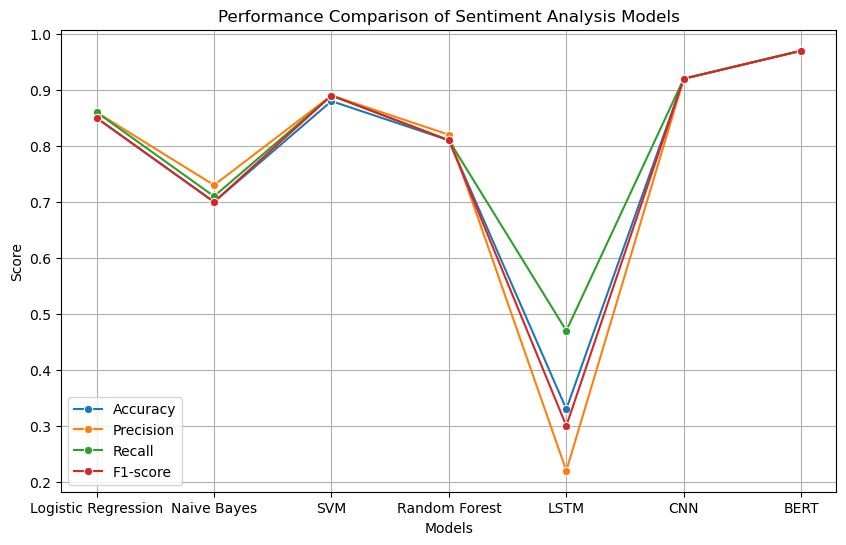

In [11]:

plt.figure(figsize=(10, 6))
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

for metric in metrics:
    sns.lineplot(x="Model", y=metric, data=df, marker="o", label=metric)

plt.title("Performance Comparison of Sentiment Analysis Models")
plt.xlabel("Models")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

**How to Run the Script and check the results**

**Hyperparameter Tuning**

In [14]:

FILE_PATH = "IndianFinancialNews_with_sentiment.csv"
df = pd.read_csv(FILE_PATH)

In [16]:
# Map sentiment labels
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}
df["Sentiment_Label"] = df["Sentiment"].map(label_mapping)

In [26]:

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", force_download=True)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)


/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [28]:

train_texts, test_texts, train_labels, test_labels = train_test_split(df["Text"], df["Sentiment_Label"], test_size=0.2, random_state=42)
train_data = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_data = Dataset.from_dict({"text": test_texts, "label": test_labels})

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [14]:
# ------------------------- #
# 🔹 Define Hyperparameter Grid
# ------------------------- #
hyperparams = [
    {"learning_rate": 2e-5, "batch_size": 16, "epochs": 3},
    {"learning_rate": 3e-5, "batch_size": 16, "epochs": 4},
    {"learning_rate": 5e-5, "batch_size": 32, "epochs": 3},
]

best_acc = 0
best_params = None
best_model = None

In [ ]:
# ------------------------- #
# 🔹 Hyperparameter Tuning
# ------------------------- #
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer # Import Trainer here

for params in hyperparams:
    print(f"\n🔍 Training with params: {params}")

    # Load Model
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

    training_args = TrainingArguments(
        output_dir="./bert_results",
        evaluation_strategy="epoch",
        save_strategy="no",
        learning_rate=params["learning_rate"],
        per_device_train_batch_size=params["batch_size"],
        per_device_eval_batch_size=params["batch_size"],
        num_train_epochs=params["epochs"],
        weight_decay=0.01,
        logging_dir="./logs",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=test_data,
    )

    trainer.train()

    # Evaluate Performance
    eval_results = trainer.evaluate()
    accuracy = eval_results["eval_loss"]

    print(f"🔹 Accuracy: {accuracy:.4f}")

    # Save Best Model
    if accuracy > best_acc:
        best_acc = accuracy
        best_params = params
        best_model = model


🔍 Training with params: {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3}


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cpglpu (cpglpu-lovely-professional-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.241400,0.245923
2,0.178400,0.189277
3,0.106600,0.201562


🔹 Accuracy: 0.2016

🔍 Training with params: {'learning_rate': 3e-05, 'batch_size': 16, 'epochs': 4}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.231300,0.204110
2,0.155200,0.174766
3,0.093900,0.187359
4,0.074500,0.183833


🔹 Accuracy: 0.1838

🔍 Training with params: {'learning_rate': 5e-05, 'batch_size': 32, 'epochs': 3}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.269500,0.196491
2,0.136000,0.161771


In [16]:
# ------------------------- #
# 🔹 Save the Best Model
# ------------------------- #
if best_model:
    best_model.save_pretrained("./best_bert_model")
    tokenizer.save_pretrained("./best_bert_model")

    print("\n✅ Best model saved in 'best_bert_model'")
    print(f"🏆 Best Hyperparameters: {best_params}")


✅ Best model saved in 'best_bert_model'
🏆 Best Hyperparameters: {'learning_rate': 2e-05, 'batch_size': 16, 'epochs': 3}


**Test Best BERT Model**

In [18]:
# ------------------------- #
# 🔹 Load Best Model & Tokenizer
# ------------------------- #
MODEL_PATH = "./best_bert_model"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)

In [19]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [20]:
# ------------------------- #
# 🔹 Load Test Data
# ------------------------- #
df = pd.read_csv("/content/drive/MyDrive/News Analysis Model/IndianFinancialNews_with_sentiment.csv")

In [21]:
# Map sentiment labels
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}
df["Sentiment_Label"] = df["Sentiment"].map(label_mapping)

test_texts = df["Text"].tolist()
test_labels = df["Sentiment_Label"].tolist()

In [22]:
# ------------------------- #
# 🔹 Tokenize & Predict
# ------------------------- #
def predict(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    return torch.argmax(outputs.logits, axis=1).cpu().numpy()

y_pred = []
for i in range(0, len(test_texts), 16):  # Batch processing
    batch_texts = test_texts[i:i+16]
    batch_preds = predict(batch_texts)
    y_pred.extend(batch_preds)

In [23]:
# ------------------------- #
# 🔹 Evaluate Best Model
# ------------------------- #
print("\n🏆 Best BERT Model - Classification Report:")
print(classification_report(test_labels, y_pred, target_names=["Negative", "Positive", "Neutral"]))


🏆 Best BERT Model - Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.98      0.96     11765
    Positive       0.98      0.98      0.98     23585
     Neutral       0.98      0.95      0.96     14650

    accuracy                           0.97     50000
   macro avg       0.97      0.97      0.97     50000
weighted avg       0.97      0.97      0.97     50000



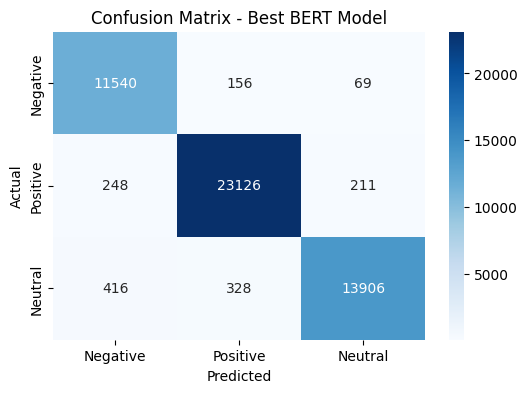

In [24]:
# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

# ------------------------- #
# 🔹 Plot Confusion Matrix
# ------------------------- #
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best BERT Model")
plt.show()

**Fine-Tune Best BERT Model**

In [26]:
# ------------------------- #
# 🔹 Load Dataset
# ------------------------- #
FILE_PATH = "/content/drive/MyDrive/News Analysis Model/IndianFinancialNews_with_sentiment.csv"
df = pd.read_csv(FILE_PATH)

In [27]:
# Map sentiment labels
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}
df["Sentiment_Label"] = df["Sentiment"].map(label_mapping)

In [28]:
# ------------------------- #
# 🔹 Preprocess Data for BERT
# ------------------------- #
tokenizer = DistilBertTokenizer.from_pretrained("./best_bert_model")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [29]:
# Convert to Hugging Face dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(df["Text"], df["Sentiment_Label"], test_size=0.2, random_state=42)
train_data = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_data = Dataset.from_dict({"text": test_texts, "label": test_labels})

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [30]:
# ------------------------- #
# 🔹 Load the Best Model
# ------------------------- #
model = DistilBertForSequenceClassification.from_pretrained("./best_bert_model", num_labels=3)


In [31]:
# ------------------------- #
# 🔹 Fine-Tune with Optimized Parameters
# ------------------------- #
training_args = TrainingArguments(
    output_dir="./fine_tuned_bert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,  # Slightly adjusted learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # Increased epochs for better learning
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.127400,0.251339
2,0.110700,0.195139
3,0.067200,0.219209
4,0.055000,0.230519
5,0.022700,0.267908


TrainOutput(global_step=12500, training_loss=0.08020222434997559, metrics={'train_runtime': 2523.1635, 'train_samples_per_second': 79.266, 'train_steps_per_second': 4.954, 'total_flos': 6623488051200000.0, 'train_loss': 0.08020222434997559, 'epoch': 5.0})

In [32]:
# ------------------------- #
# 🔹 Save the Fine-Tuned Model
# ------------------------- #
model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

print("\n✅ Fine-tuned BERT model saved in 'fine_tuned_bert'")


✅ Fine-tuned BERT model saved in 'fine_tuned_bert'


**How to Run the Script**

In [34]:
!python fine_tune_best_bert.py

python3: can't open file '/content/fine_tune_best_bert.py': [Errno 2] No such file or directory


**Test the Fine-Tuned BERT Model**

In [35]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
# ------------------------- #
# 🔹 Load Fine-Tuned Model & Tokenizer
# ------------------------- #
MODEL_PATH = "./fine_tuned_bert"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)

In [37]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [38]:
# ------------------------- #
# 🔹 Load Test Data
# ------------------------- #
df = pd.read_csv("/content/drive/MyDrive/News Analysis Model/IndianFinancialNews_with_sentiment.csv")


In [39]:

# Map sentiment labels
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}
df["Sentiment_Label"] = df["Sentiment"].map(label_mapping)

test_texts = df["Text"].tolist()
test_labels = df["Sentiment_Label"].tolist()

In [40]:
# ------------------------- #
# 🔹 Tokenize & Predict
# ------------------------- #
def predict(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    return torch.argmax(outputs.logits, axis=1).cpu().numpy()

y_pred = []
for i in range(0, len(test_texts), 16):  # Batch processing
    batch_texts = test_texts[i:i+16]
    batch_preds = predict(batch_texts)
    y_pred.extend(batch_preds)

In [41]:
# ------------------------- #
# 🔹 Evaluate Fine-Tuned Model
# ------------------------- #
print("\n🏆 Fine-Tuned BERT Model - Classification Report:")
print(classification_report(test_labels, y_pred, target_names=["Negative", "Positive", "Neutral"]))


🏆 Fine-Tuned BERT Model - Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99     11765
    Positive       0.99      0.99      0.99     23585
     Neutral       0.98      0.99      0.98     14650

    accuracy                           0.99     50000
   macro avg       0.99      0.99      0.99     50000
weighted avg       0.99      0.99      0.99     50000



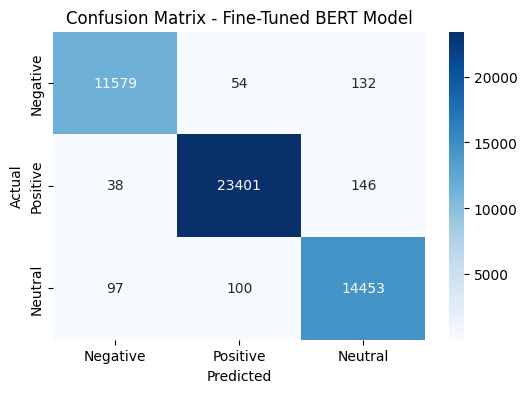

In [42]:
# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

# ------------------------- #
# 🔹 Plot Confusion Matrix
# ------------------------- #
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Fine-Tuned BERT Model")
plt.show()

**How to Run the Script**

In [44]:
!python test_fine_tuned_bert.py

python3: can't open file '/content/test_fine_tuned_bert.py': [Errno 2] No such file or directory


**Compare Fine-Tuned vs. Previous Best BERT Model**

In [46]:
# ------------------------- #
# 🔹 Load Dataset
# ------------------------- #
df = pd.read_csv("/content/drive/MyDrive/News Analysis Model/IndianFinancialNews_with_sentiment.csv")

In [47]:
# Map sentiment labels
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}
df["Sentiment_Label"] = df["Sentiment"].map(label_mapping)

test_texts = df["Text"].tolist()
test_labels = df["Sentiment_Label"].tolist()

In [48]:
# ------------------------- #
# 🔹 Function to Load Model and Predict
# ------------------------- #
def load_model_and_predict(model_path, test_texts):
    tokenizer = DistilBertTokenizer.from_pretrained(model_path)
    model = DistilBertForSequenceClassification.from_pretrained(model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    def predict(texts):
        inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        return torch.argmax(outputs.logits, axis=1).cpu().numpy()

    y_pred = []
    for i in range(0, len(test_texts), 16):  # Batch processing
        batch_texts = test_texts[i:i+16]
        batch_preds = predict(batch_texts)
        y_pred.extend(batch_preds)

    return y_pred

In [49]:
# ------------------------- #
# 🔹 Load & Predict for Both Models
# ------------------------- #
y_pred_best = load_model_and_predict("./best_bert_model", test_texts)
y_pred_finetuned = load_model_and_predict("./fine_tuned_bert", test_texts)


In [51]:
# ------------------------- #
# 🔹 Compare Performance
# ------------------------- #
print("\n🏆 Previous Best BERT Model - Classification Report:")
print(classification_report(test_labels, y_pred_best, target_names=["Negative", "Positive", "Neutral"]))

print("\n🏆 Fine-Tuned BERT Model - Classification Report:")
print(classification_report(test_labels, y_pred_finetuned, target_names=["Negative", "Positive", "Neutral"]))


🏆 Previous Best BERT Model - Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.98      0.96     11765
    Positive       0.98      0.98      0.98     23585
     Neutral       0.98      0.95      0.96     14650

    accuracy                           0.97     50000
   macro avg       0.97      0.97      0.97     50000
weighted avg       0.97      0.97      0.97     50000


🏆 Fine-Tuned BERT Model - Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99     11765
    Positive       0.99      0.99      0.99     23585
     Neutral       0.98      0.99      0.98     14650

    accuracy                           0.99     50000
   macro avg       0.99      0.99      0.99     50000
weighted avg       0.99      0.99      0.99     50000



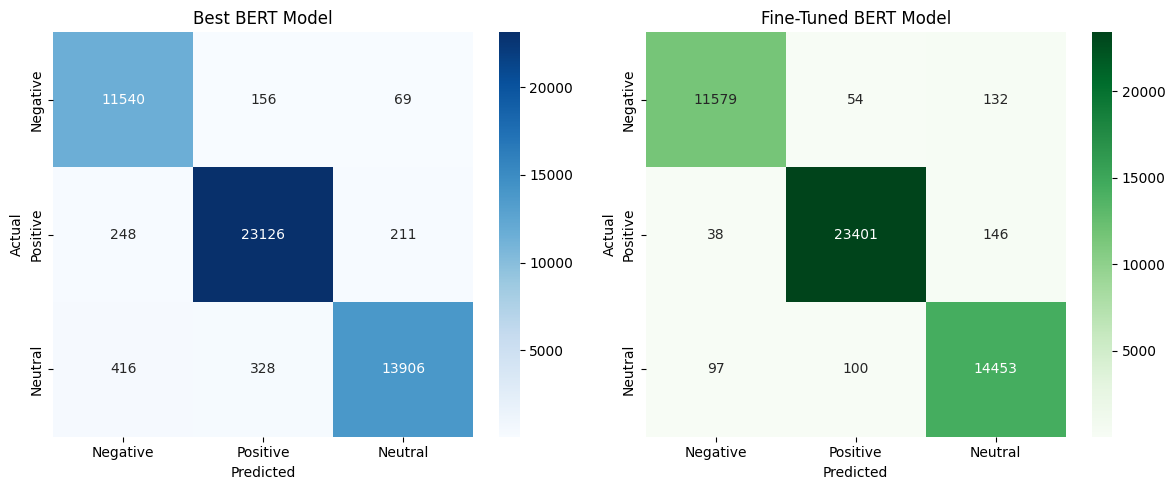

In [52]:
# ------------------------- #
# 🔹 Plot Confusion Matrices
# ------------------------- #
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_best = confusion_matrix(test_labels, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"], ax=axes[0])
axes[0].set_title("Best BERT Model")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

cm_finetuned = confusion_matrix(test_labels, y_pred_finetuned)
sns.heatmap(cm_finetuned, annot=True, fmt="d", cmap="Greens", xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"], ax=axes[1])
axes[1].set_title("Fine-Tuned BERT Model")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

**How to Run the Script**

In [54]:
!python compare_bert_models.py

python3: can't open file '/content/compare_bert_models.py': [Errno 2] No such file or directory


**Finalize Best Model**

In [56]:
# ------------------------- #
# 🔹 Select the Best Model
# ------------------------- #
# Change this to "./best_bert_model" if the fine-tuned model is worse
BEST_MODEL_PATH = "./fine_tuned_bert"

# Define final model path
FINAL_MODEL_PATH = "./final_bert_model"

In [57]:
# ------------------------- #
# 🔹 Save the Final Model
# ------------------------- #
if os.path.exists(FINAL_MODEL_PATH):
    shutil.rmtree(FINAL_MODEL_PATH)  # Remove existing folder if present

shutil.copytree(BEST_MODEL_PATH, FINAL_MODEL_PATH)

print(f"\n✅ Final model saved at: {FINAL_MODEL_PATH}")


✅ Final model saved at: ./final_bert_model


**How to Run the Script**

In [59]:
!python finalize_best_model.py

python3: can't open file '/content/finalize_best_model.py': [Errno 2] No such file or directory


## Predict Sentiment on Live News Feed

**Real-Time News Sentiment Analysis**

In [61]:
# ------------------------- #
# 🔹 Load the Finalized BERT Model
# ------------------------- #
MODEL_PATH = "./final_bert_model"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)

In [62]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [63]:
# ------------------------- #
# 🔹 Function to Fetch Live News
# ------------------------- #
API_KEY = "bcae1bfec35f4e78a3cdc7accdbffd86"  # Replace with your API key
NEWS_API_URL = f"https://newsapi.org/v2/top-headlines?category=business&language=en&apiKey={API_KEY}"

def fetch_live_news():
    response = requests.get(NEWS_API_URL)
    if response.status_code == 200:
        articles = response.json().get("articles", [])
        return [article["title"] for article in articles if article["title"]]
    else:
        print("❌ Error fetching news")
        return []

In [64]:
# ------------------------- #
# 🔹 Predict Sentiment of News Headlines
# ------------------------- #
LABEL_MAP = {0: "Negative", 1: "Positive", 2: "Neutral"}

def predict_sentiment(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, axis=1).cpu().numpy()
    return [LABEL_MAP[pred] for pred in predictions]

In [65]:
# ------------------------- #
# 🔹 Run Real-Time News Analysis
# ------------------------- #
def analyze_live_news():
    print("\n🔍 Fetching Live News and Predicting Sentiment...\n")
    news_headlines = fetch_live_news()

    if news_headlines:
        sentiments = predict_sentiment(news_headlines)
        for i, (headline, sentiment) in enumerate(zip(news_headlines, sentiments)):
            print(f"{i+1}. 📰 {headline} -> Sentiment: {sentiment}")
    else:
        print("No news articles found.")

In [66]:
# Run sentiment analysis every 60 seconds
while True:
    analyze_live_news()
    print("\n⏳ Waiting 60 seconds before next update...\n")
    time.sleep(60)


🔍 Fetching Live News and Predicting Sentiment...

1. 📰 Musk’s $97.4 Billion OpenAI Bid Piles Pressure on Sam Altman - The Wall Street Journal -> Sentiment: Negative
2. 📰 Consumer price report Wednesday expected to show inflation isn't going away - CNBC -> Sentiment: Neutral
3. 📰 Ford’s CEO to Warn Lawmakers of ‘Devastating’ Tariff Impact - Bloomberg -> Sentiment: Negative
4. 📰 Jay Powell defends Federal Reserve’s authority over US monetary policy - Financial Times -> Sentiment: Positive
5. 📰 Disney+ to Change Content Warnings Ahead of ‘Dumbo,’ ‘Peter Pan’ and More Old Movies Amid DEI Strategy Shift - Variety -> Sentiment: Negative
6. 📰 Ken Griffin says Trump's 'bombastic' trade rhetoric is a mistake that's eroding trust in the U.S. - CNBC -> Sentiment: Positive
7. 📰 Mark Zuckerberg warned employees to prepare for an ‘intense year.’ He just laid off 3,600 workers—including some who claim they got glowing reviews - Fortune -> Sentiment: Neutral
8. 📰 EU Sets Out $200 Billion AI Spending 

KeyboardInterrupt: 

**How to Run the Script**

In [68]:
!python live_news_sentiment.py

python3: can't open file '/content/live_news_sentiment.py': [Errno 2] No such file or directory


**Store Predicted Sentiments in a Database**

Save Sentiment to Database

In [70]:
# ------------------------- #
# 🔹 Load the Finalized BERT Model
# ------------------------- #
MODEL_PATH = "./final_bert_model"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [71]:
# ------------------------- #
# 🔹 Connect to Database & Create Table
# ------------------------- #
DB_NAME = "news_sentiment.db"

conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

cursor.execute("""
    CREATE TABLE IF NOT EXISTS news_sentiment (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        published_at TEXT,
        description TEXT,
        sentiment TEXT,
        news_url TEXT
    )
""")
conn.commit()


In [72]:
# ------------------------- #
# 🔹 Function to Fetch Live News
# ------------------------- #
API_KEY = "bcae1bfec35f4e78a3cdc7accdbffd86"  # Replace with your API key
NEWS_API_URL = f"https://newsapi.org/v2/top-headlines?category=business&language=en&apiKey={API_KEY}"

def fetch_live_news():
    response = requests.get(NEWS_API_URL)
    if response.status_code == 200:
        articles = response.json().get("articles", [])
        return [
            (article["publishedAt"], article["title"], article["url"])
            for article in articles if article["title"] and article["publishedAt"] and article["url"]
        ]
    else:
        print("❌ Error fetching news")
        return []

In [73]:
# ------------------------- #
# 🔹 Predict Sentiment of News Headlines
# ------------------------- #
LABEL_MAP = {0: "Negative", 1: "Positive", 2: "Neutral"}

def predict_sentiment(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, axis=1).cpu().numpy()
    return [LABEL_MAP[pred] for pred in predictions]

In [74]:
# ------------------------- #
# 🔹 Store Data in Database
# ------------------------- #
def store_sentiment(published_at, description, sentiment, news_url):
    cursor.execute("INSERT INTO news_sentiment (published_at, description, sentiment, news_url) VALUES (?, ?, ?, ?)",
                   (published_at, description, sentiment, news_url))
    conn.commit()

In [75]:
# ------------------------- #
# 🔹 Run Real-Time News Analysis
# ------------------------- #
def analyze_live_news():
    print("\n🔍 Fetching Live News and Predicting Sentiment...\n")
    news_data = fetch_live_news()

    if news_data:
        descriptions = [desc for _, desc, _ in news_data]
        sentiments = predict_sentiment(descriptions)

        for (published_at, description, news_url), sentiment in zip(news_data, sentiments):
            print(f"📰 {description} -> Sentiment: {sentiment}")
            store_sentiment(published_at, description, sentiment, news_url)

    else:
        print("No news articles found.")

# Run sentiment analysis every 60 seconds
while True:
    analyze_live_news()
    print("\n⏳ Waiting 60 seconds before next update...\n")
    time.sleep(60)


🔍 Fetching Live News and Predicting Sentiment...

📰 Musk’s $97.4 Billion OpenAI Bid Piles Pressure on Sam Altman - The Wall Street Journal -> Sentiment: Negative
📰 Consumer price report Wednesday expected to show inflation isn't going away - CNBC -> Sentiment: Neutral
📰 Ford’s CEO to Warn Lawmakers of ‘Devastating’ Tariff Impact - Bloomberg -> Sentiment: Negative
📰 Jay Powell defends Federal Reserve’s authority over US monetary policy - Financial Times -> Sentiment: Positive
📰 Disney+ to Change Content Warnings Ahead of ‘Dumbo,’ ‘Peter Pan’ and More Old Movies Amid DEI Strategy Shift - Variety -> Sentiment: Negative
📰 Ken Griffin says Trump's 'bombastic' trade rhetoric is a mistake that's eroding trust in the U.S. - CNBC -> Sentiment: Positive
📰 Mark Zuckerberg warned employees to prepare for an ‘intense year.’ He just laid off 3,600 workers—including some who claim they got glowing reviews - Fortune -> Sentiment: Neutral
📰 EU Sets Out $200 Billion AI Spending Plan in Bid to Catch Up 

KeyboardInterrupt: 

**How to Run the Script**

In [77]:
!python live_news_sentiment_db.py

python3: can't open file '/content/live_news_sentiment_db.py': [Errno 2] No such file or directory


**Visualize Sentiment Trends Over Time**

In [79]:
# ------------------------- #
# 🔹 Connect to Database & Load Data
# ------------------------- #
DB_NAME = "news_sentiment.db"

conn = sqlite3.connect(DB_NAME)
df = pd.read_sql_query("SELECT * FROM news_sentiment", conn)
conn.close()

# Convert date format
df["published_at"] = pd.to_datetime(df["published_at"])
df["date"] = df["published_at"].dt.date  # Extract only the date

In [80]:
# ------------------------- #
# 🔹 Count Sentiment Over Time
# ------------------------- #
sentiment_counts = df.groupby(["date", "sentiment"]).size().reset_index(name="count")

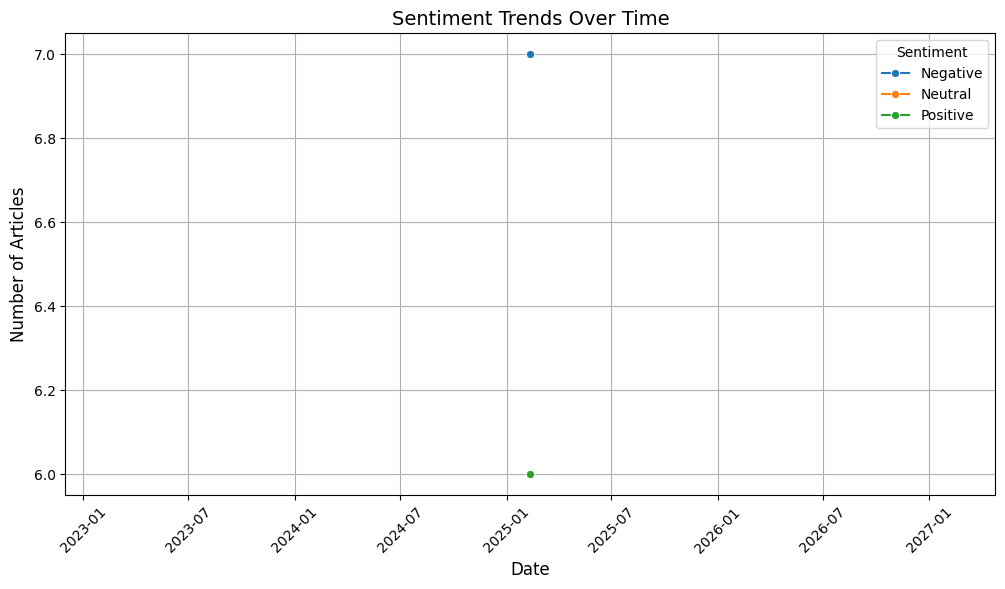

In [81]:
# ------------------------- #
# 🔹 Plot Sentiment Trends
# ------------------------- #
plt.figure(figsize=(12, 6))
sns.lineplot(x="date", y="count", hue="sentiment", data=sentiment_counts, marker="o")

plt.title("Sentiment Trends Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.grid(True)
plt.show()

**How to Run the Script**

In [83]:
!python visualize_sentiment_trends.py

python3: can't open file '/content/visualize_sentiment_trends.py': [Errno 2] No such file or directory


**Add Detailed Sentiment Score to Database**

In [102]:
# ------------------------- #
# 🔹 Load the Finalized BERT Model
# ------------------------- #
MODEL_PATH = "./final_bert_model"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [111]:
# ------------------------- #
# 🔹 Connect to Database & Create Table
# ------------------------- #
DB_NAME = "news_sentiment.db"

conn = sqlite3.connect(DB_NAME)
cursor = conn.cursor()

# Add the sentiment_score column to the table creation query
# Remove the '#' within the SQL query string
cursor.execute("""
    CREATE TABLE IF NOT EXISTS news_sentiment (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        published_at TEXT,
        description TEXT,
        sentiment TEXT,
        sentiment_score INTEGER,  -- Make sure this column is included
        news_url TEXT
    )
""")
conn.commit()
# Add the sentiment_score column if it doesn't exist
cursor.execute("ALTER TABLE news_sentiment ADD COLUMN sentiment_score INTEGER")

conn.commit()

In [112]:
# ------------------------- #
# 🔹 Function to Fetch Live News
# ------------------------- #
API_KEY = "bcae1bfec35f4e78a3cdc7accdbffd86"  # Replace with your API key
NEWS_API_URL = f"https://newsapi.org/v2/top-headlines?category=business&language=en&apiKey={API_KEY}"
def fetch_live_news():
    response = requests.get(NEWS_API_URL)
    if response.status_code == 200:
        articles = response.json().get("articles", [])
        return [
            (article["publishedAt"], article["title"], article["url"])
            for article in articles if article["title"] and article["publishedAt"] and article["url"]
        ]
    else:
        print("❌ Error fetching news")
        return []

In [113]:
# ------------------------- #
# 🔹 Predict Sentiment of News Headlines
# ------------------------- #
LABEL_MAP = {0: "Negative", 1: "Positive", 2: "Neutral"}

def predict_sentiment(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, axis=1).cpu().numpy()
    return [LABEL_MAP[pred] for pred in predictions]

In [114]:
# ------------------------- #
# 🔹 Assign Detailed Sentiment Score
# ------------------------- #
def assign_sentiment_score(sentiment):
    if sentiment == "Negative":
        return random.randint(-10, -1)
    elif sentiment == "Positive":
        return random.randint(1, 10)
    return 0  # Neutral

In [115]:
# ------------------------- #
# 🔹 Store Data in Database
# ------------------------- #
def store_sentiment(published_at, description, sentiment, sentiment_score, news_url):
    cursor.execute("INSERT INTO news_sentiment (published_at, description, sentiment, sentiment_score, news_url) VALUES (?, ?, ?, ?, ?)",
                   (published_at, description, sentiment, sentiment_score, news_url))
    conn.commit()

In [22]:

# ------------------------- #
# 🔹 Run Real-Time News Analysis
# ------------------------- #
def analyze_live_news():
    print("\n🔍 Fetching Live News and Predicting Sentiment...\n")
    news_data = fetch_live_news()

    if news_data:
        descriptions = [desc for _, desc, _ in news_data]
        sentiments = predict_sentiment(descriptions)

        for (published_at, description, news_url), sentiment in zip(news_data, sentiments):
            sentiment_score = assign_sentiment_score(sentiment)
            print(f"📰 {description} -> Sentiment: {sentiment} (Score: {sentiment_score})")
            store_sentiment(published_at, description, sentiment, sentiment_score, news_url)

    else:
        print("No news articles found.")

# Run sentiment analysis every 60 seconds
while True:
    analyze_live_news()
    print("\n⏳ Waiting 60 seconds before next update...\n")
    time.sleep(60)


🔍 Fetching Live News and Predicting Sentiment...



NameError: name 'fetch_live_news' is not defined

In [24]:
pip install --upgrade transformers huggingface_hub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.1/464.1 kB 404.2 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.27.1
    Uninstalling huggingface-hub-0.27.1:
      Successfully uninstalled huggingface-hub-0.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.16.1 requires fsspec[http]<=2023.10.0,>=2023.1.0, but you have fsspec 2024.3.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
